In [80]:
import warnings
warnings.simplefilter(action='ignore')

In [82]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown

In [83]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [ ]:
adata = sc.read('tyser.h5ad')
#hips = sc.read("hiPSC.h5ad")

In [86]:
adata.T

AnnData object with n_obs × n_vars = 57490 × 1069
    obs: 'features'
    var: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt'

In [87]:
print(adata.X.shape)
print(adata.X[:5, :5])  # View a small slice

(1069, 57490)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (5, 5)>
  Coords	Values
  (0, 0)	2.0
  (2, 0)	2.0
  (4, 1)	1.0


In [88]:
#adata.X = adata.layers["counts"].copy()
# Use adata.X directly, as it contains raw counts.
adata.X = adata.X.copy()


In [89]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)

In [90]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [91]:
sc.pp.normalize_total(adata)

In [92]:
sc.pp.log1p(adata)

In [93]:
print(adata.obs.keys())


Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name',
       'Characteristics.sampling.site.',
       'Characteristics.inferred.cell.type...authors.labels.',
       'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id',
       'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint',
       'percent.mt'],
      dtype='object')


In [111]:
print(adata.obs.columns)  # Lijst van alle kolommen in adata.obs
#print(hips.obs) 

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name',
       'Characteristics.sampling.site.',
       'Characteristics.inferred.cell.type...authors.labels.',
       'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id',
       'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint',
       'percent.mt'],
      dtype='object')


In [ ]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="",
    subset=True)

In [14]:
select_terms = adata.varm['I'].sum(0) > 12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [15]:
adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

NameError: name 'tyser_obs' is not defined

In [18]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='Characteristics.inferred.cell.type...authors.labels.',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1974 256 11
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 263
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  263 0 0 11 1974
	with hard mask.
Last Decoder layer: softmax


In [19]:
ALPHA = 0.7

In [21]:
adata.X = adata.X.astype(np.float32)

In [23]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Preparing (1069, 1974)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - epoch_loss: 1982.6262054443 - epoch_recon_loss: 1943.7136993408 - epoch_kl_loss: 77.8250494003 - val_loss: 2025.0759277344 - val_recon_loss: 1990.2504882812 - val_kl_loss: 69.650756835952
Saving best state of network...
Best State was in Epoch 399


In [24]:
MEAN = False

In [25]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [26]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [27]:
sc.tl.umap(adata)

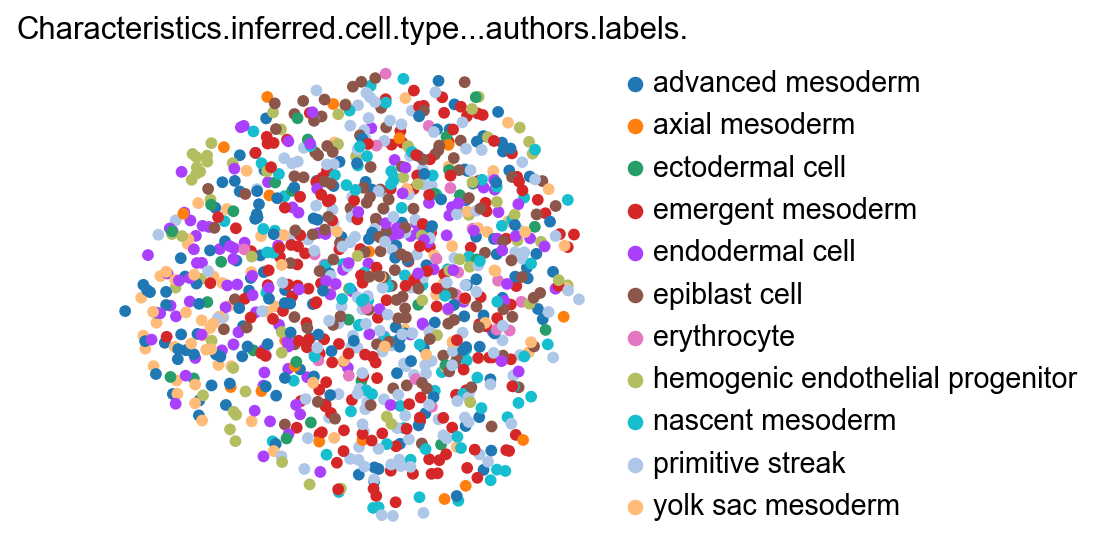

In [29]:
sc.pl.umap(adata, color=['Characteristics.inferred.cell.type...authors.labels.'], frameon=False)

In [31]:
# Lees de query-dataset
hips = sc.read('hiPSC.h5ad')

# Controleer de overlap van genen
missing_genes = [gene for gene in adata.var_names if gene not in hips.var_names]
print(f"Aantal genen in hips die niet in tyser staan: {len(missing_genes)}")
print("Ontbrekende genen:", missing_genes)

Aantal genen in hips die niet in tyser staan: 13
Ontbrekende genen: ['ABCA6', 'ALB', 'COL4A3BP', 'CTGF', 'IL2RG', 'IL3', 'NT5C1B', 'OR1D2', 'OR2W3', 'PLA2G16', 'ROCK1P1', 'RPL23AP42', 'ZIM2']


In [33]:
# Filter genen die aanwezig zijn in beide datasets
common_genes = [gene for gene in adata.var_names if gene in hips.var_names]

# Pas de filtering toe op beide datasets
hips = hips[:, common_genes].copy()
adata = adata[:, common_genes].copy()

In [41]:
hips = sc.read('hiPSC.h5ad')[:, hips.var_names].copy()

In [42]:
# Controleer of var_names overeenkomen
print("Aantal genen in beide datasets na filtering:", len(common_genes))
print("Zijn genen nu identiek?", np.array_equal(hips.var_names, hips.var_names))

Aantal genen in beide datasets na filtering: 1961
Zijn genen nu identiek? True


In [46]:
hips.obs['Characteristics.inferred.cell.type...authors.labels.'] = 'Kang'

In [47]:
hips.obs

,orig.ident,nCount_RNA,nFeature_RNA,run,sample_name,percent.mt,percent.dissoc,RNA_snn_res.0.3,seurat_clusters,RNA_snn_res.0.22,Characteristics.inferred.cell.type...authors.labels.
batch_2_A_AAACCCAAGGTAATCA-1,SeuratProject,48806.0,6892,0h_A,iPSC_99_4,5.110027,0.013308,2,Kang,0,Kang
batch_2_A_AAAGGATCATCCAATG-1,SeuratProject,5460.0,2307,0h_A,iPSC_99_4,0.201465,0.015073,7,Kang,0,Kang
batch_2_A_AAAGGATGTGGTCAAG-1,SeuratProject,32899.0,5707,0h_A,iPSC_99_4,4.097389,0.014101,2,Kang,0,Kang
batch_2_A_AAAGGTAGTGTCATCA-1,SeuratProject,37327.0,6069,0h_A,iPSC_99_4,4.532912,0.013420,2,Kang,0,Kang
batch_2_A_AAATGGACATATCTGG-1,SeuratProject,18633.0,4701,0h_A,iPSC_99_4,4.932110,0.013176,2,Kang,0,Kang
...,...,...,...,...,...,...,...,...,...,...,...
batch_1_sample_120H_TTTACTGCATCCGCGA-1,SeuratProject,14013.0,4629,120h,iPSC_72_1,4.767002,0.017398,3,Kang,2,Kang
batch_1_sample_120H_TTTCACATCAGCCCAG-1,SeuratProject,21173.0,5140,120h,iPSC_72_1,4.127899,0.014142,5,Kang,4,Kang
batch_1_sample_120H_TTTCAGTAGTACAGAT-1,SeuratProject,22107.0,5437,120h,iPSC_72_1,2.035554,0.013721,3,Kang,2,Kang
batch_1_sample_120H_TTTGATCAGCTCCATA-1,SeuratProject,12806.0,4127,120h,iPSC_72_1,3.428081,0.015297,3,Kang,2,Kang


In [48]:
hips.uns['terms'] = adata.uns['terms']

In [49]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(hips, intr_cvae)

Query data is missing expression data of  13  genes which were contained in the reference dataset.
The missing information will be filled with zeroes.
AnnData object with n_obs × n_vars = 4694 × 1974
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'run', 'sample_name', 'percent.mt', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22', 'Characteristics.inferred.cell.type...authors.labels.'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1974 256 12
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 263
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  263 0 0 12 1974
	with hard mask.
Last Decoder layer: softmax


In [50]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)


Preparing (4694, 1974)
Instantiating dataset
 |███████-------------| 38.2%  - val_loss: 1774.2120361328 - val_recon_loss: 1768.7204895020 - val_kl_loss: 54.9153423309
ADJUSTED LR
 |████████------------| 43.2%  - val_loss: 1772.0509948730 - val_recon_loss: 1766.5440063477 - val_kl_loss: 55.0695686340
ADJUSTED LR
 |█████████-----------| 45.0%  - val_loss: 1770.9475097656 - val_recon_loss: 1765.4391174316 - val_kl_loss: 55.0841112137
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 158


In [51]:
kang_pbmc = sc.AnnData.concatenate(adata, hips, batch_key='batch_join', uns_merge='same')

In [73]:
adata

AnnData object with n_obs × n_vars = 1069 × 1961
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'terms', 'log1p', 'hvg', 'neighbors', 'umap', 'Characteristics.inferred.cell.type...authors.labels._colors'
    obsm: 'X_cvae', 'X_umap'
    varm: 'I'
    obsp: 'distances', 'connectivities'

In [59]:
kang_pbmc.X = kang_pbmc.X.astype(np.float32)

In [66]:
kang_pbmc.obs

,orig.ident,nCount_RNA,nFeature_RNA,Source.Name,Characteristics.sampling.site.,Characteristics.inferred.cell.type...authors.labels.,Characteristics.inferred.cell.type...ontology.labels.,cluster_id,sub_cluster,origin,run,sample_name,timepoint,percent.mt,percent.dissoc,RNA_snn_res.0.3,seurat_clusters,RNA_snn_res.0.22,batch_join
SS.sc7786612-0,0,259888.990001,6942,SS.sc7786612,rostral,endodermal cell,endodermal cell,Endoderm,DE(P),tyser,tyser,tyser,tyser,1.304482,NaN,NaN,NaN,NaN,0
SS.sc7786605-0,0,437911.014986,6140,SS.sc7786605,rostral,advanced mesoderm,mesoderm cell,Advanced Mesoderm,Advanced Mesoderm,tyser,tyser,tyser,tyser,1.295160,NaN,NaN,NaN,NaN,0
SS.sc7785737-0,0,322351.983054,3800,SS.sc7785737,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.294179,NaN,NaN,NaN,NaN,0
SS.sc7785398-0,0,394318.996000,2964,SS.sc7785398,yolk sac,yolk sac mesoderm,mesenchyme of yolk sac,ExE Mesoderm,YS Mesoderm,tyser,tyser,tyser,tyser,1.423720,NaN,NaN,NaN,NaN,0
SS.sc7788091-0,0,298217.993000,5030,SS.sc7788091,caudal,axial mesoderm,chordamesodermal cell,Axial Mesoderm,Axial Mesoderm,tyser,tyser,tyser,tyser,1.327328,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
batch_1_sample_120H_TTTACTGCATCCGCGA-1-1,SeuratProject,14013.000000,4629,NaN,NaN,Kang,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,4.767002,0.017398,3,Kang,2.0,1
batch_1_sample_120H_TTTCACATCAGCCCAG-1-1,SeuratProject,21173.000000,5140,NaN,NaN,Kang,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,4.127899,0.014142,5,Kang,4.0,1
batch_1_sample_120H_TTTCAGTAGTACAGAT-1-1,SeuratProject,22107.000000,5437,NaN,NaN,Kang,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,2.035554,0.013721,3,Kang,2.0,1
batch_1_sample_120H_TTTGATCAGCTCCATA-1-1,SeuratProject,12806.000000,4127,NaN,NaN,Kang,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,3.428081,0.015297,3,Kang,2.0,1


In [ ]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['Characteristics.inferred.cell.type...authors.labels.'], mean=MEAN, only_active=True)

In [ ]:
#kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['Characteristics.inferred.cell.type...authors.labels.'], mean=MEAN, only_active=True)
q_intr_cvae.get_latent()

(4694, 263)